## Load libraries

In [1]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from vae_utils import VAEUtils
import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

RDKit WARNING: [00:11:09] Enabling RDKit 2019.09.2 jupyter extensions
Using TensorFlow backend.


# Load a model

In [2]:
vae = VAEUtils(directory='/Users/user/Desktop/MyGitHub/chemical_vae/examples/zinc_properties')

From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:439: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3540: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



AttributeError: can't set attribute

# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [72]:
smiles_1 = mu.canon_smiles('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
smiles_2= mu.canon_smiles('CN1CCCC1C2=CN=CC=C2')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

X_2 = vae.smiles_to_hot(smiles_2,canonize_smiles=True)
z_2 = vae.encode(X_2)
X_r2= vae.decode(z_2)


print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))
print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

print('{:20s} : {}'.format('Input',smiles_2))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r2,strip=True)[0]))
print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_2.shape, np.linalg.norm(z_2)))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]]
Input                : Cn1c(=O)c2c(ncn2C)n(C)c1=O
Reconstruction       : Cn1c(=O)c2c(ncn2F)n(C)c1=O
Z representation     : (1, 196) with norm 13.019
Input                : CN1CCCC1c1cccnc1
Reconstruction       : CN1CCC(Nc2cccnc1
Z representation     : (1, 196) with norm 12.491


## property preditor

In [71]:
print('Properties (qed,SAS,logP):')

print(len(z_1[0]))
print(z_2)

y_1 = vae.predict_prop_Z(z_1)[0]
y_2 = vae.predict_prop_Z(z_2)[0]
print(y_1)
print(y_2)

Properties (qed,SAS,logP):
196
[[ 0.51208813 -0.84223828 -0.42346702  0.75762803  1.55979595  1.62751367
  -1.84067833  0.27553946  1.11363313 -0.29340414  1.35940482 -1.03380171
  -0.02242377 -1.89620142 -1.7133664   0.91745296 -1.20626899  0.09393584
   1.65377773 -0.69044271 -0.10379643  1.51230591 -0.03991732  0.36267154
   0.81700647 -0.79468356  0.87279907  0.22394668  0.74318921  2.17186233
   0.33082747 -0.30796264  0.46262823  0.0401232  -0.02014255 -1.80564469
  -1.07612045 -0.47645338 -1.14096071  0.87762696 -0.13999926  0.14013604
  -0.18305415  0.21867793  0.23438158  0.3608125   0.92341895  1.07163444
   0.99247832  0.06557866 -0.00794844  1.30043623  0.16405705 -0.05393881
  -0.19083355  1.36472385 -0.16582104 -0.67306767 -0.41099509 -2.1704698
   1.85852529  0.24739707  0.85931141  1.7684774  -1.81298742  1.01827743
  -0.61509902  1.49699885 -0.47235388  0.04651515 -0.66343838 -0.91550167
   0.62782278 -0.36447029  0.8635265   1.49807634  1.11207183  0.28727313
   0.277

## Decode several attempts
VAE are probabilistic

Searching molecules randomly sampled from 10.00 std (z-distance) from the point
Found 51 unique mols, out of 8525
SMILES
 0                            Cn1c(=O)c2c(ncn2C)n(C)c1=O
1     Cn1c(=O)c2c(ncn2C)n(C)c1=O                    ...
2                            Cn1C(=O)c2c(ncn2C)n(C)c1=O
3                            Cn1c(=O)c2c(ncn2C)N(C)c1=O
4                            CN1c(=O)c2c(ncn2C)n(C)c1=O
5                            Cn1c(=O)c2c(ncn2C)n(C)C1=O
6                            Cn1c(=O)c2c(ncn2S)n(C)c1=O
7                            Cn1c(=O)c2c(nnn2C)n(C)c1=O
8                            Cn1c(=O)c2c(cnn2C)n(C)c1=O
9                            Cn1c(=O)c2c(ncn2F)N(C)c1=O
10                           CN1c(=O)c2c(ncn2F)n(C)c1=O
11                           Cn1c(=O)c2c(ncn2F)n(C)C1=O
12                           Cn1c(=O)c2c(ncn2F)n(C)c1=O
13                           Cn1C(=O)c2c(ncn2F)n(C)c1=O
14                           Cn1c(=O)c2c(cnn2F)n(C)c1=O
15                           Cn1c(=O)c

C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


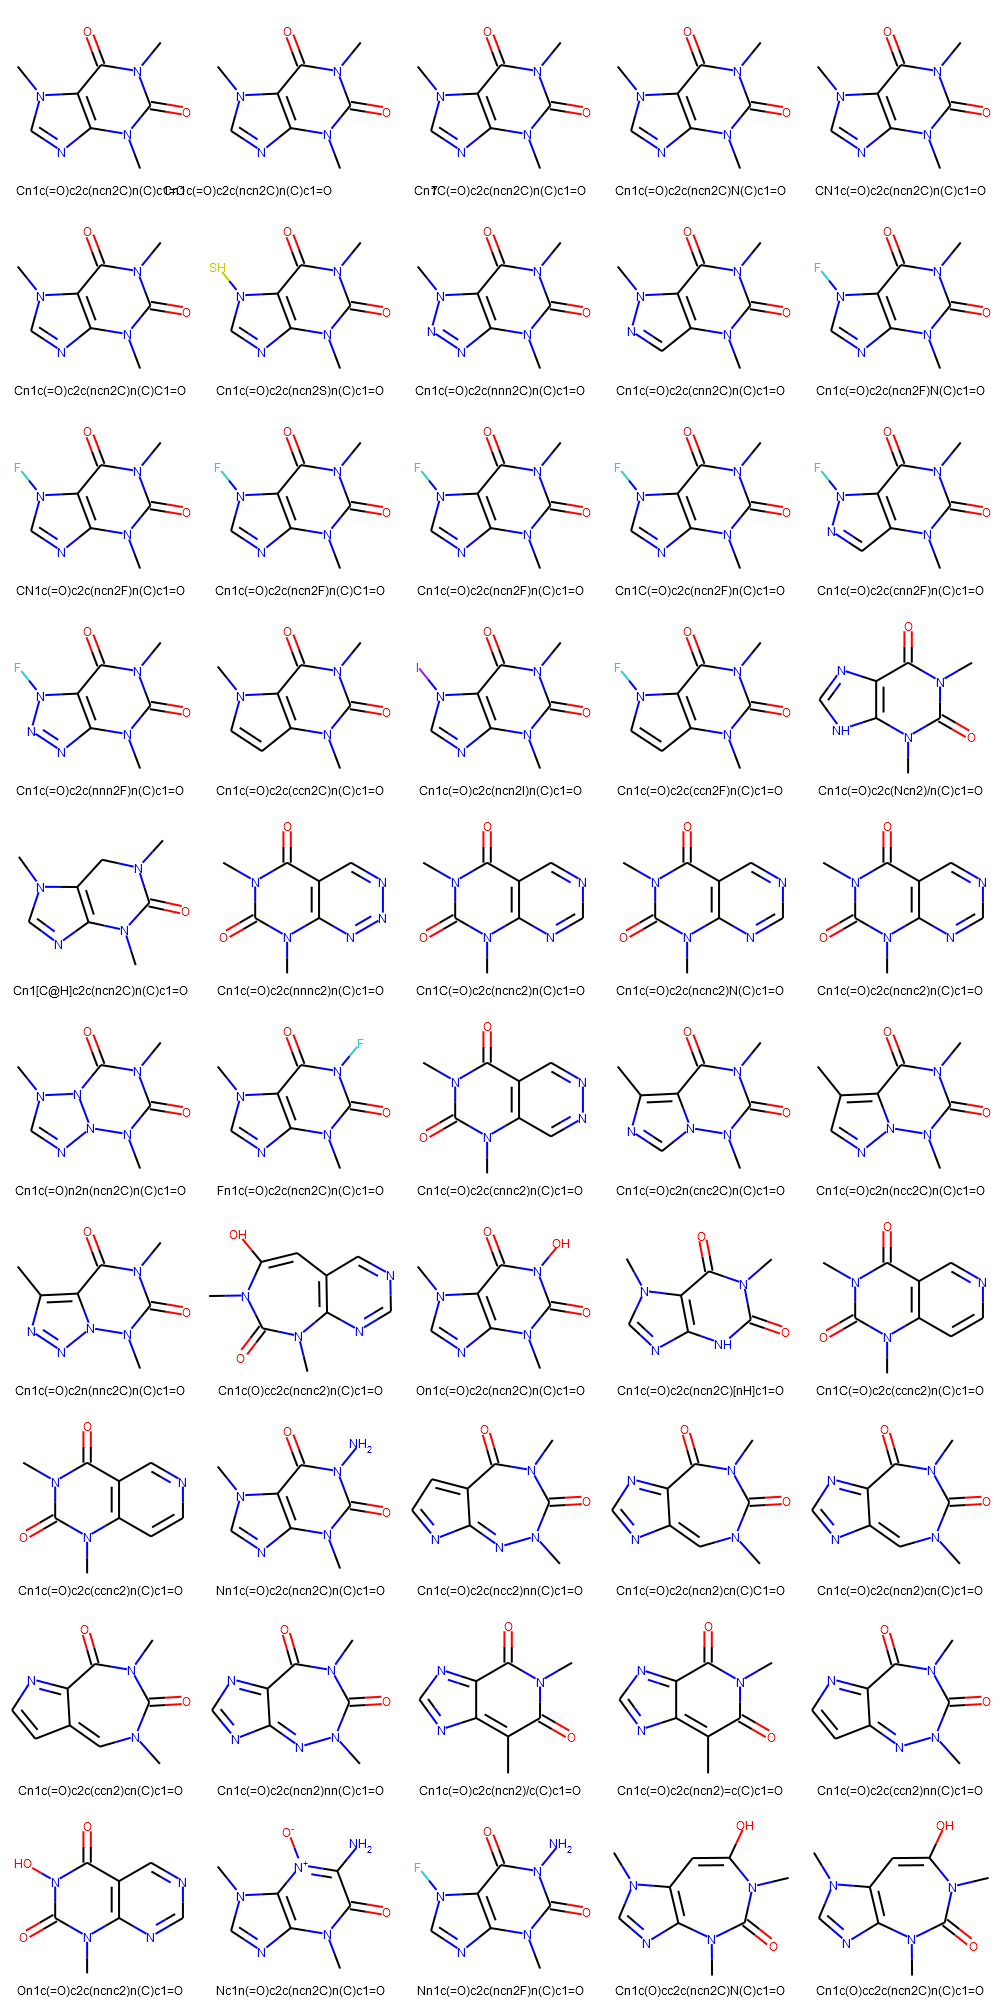

                                               smiles   distance  count  \
0                          Cn1c(=O)c2c(ncn2C)n(C)c1=O   0.000004   5900   
1   Cn1c(=O)c2c(ncn2C)n(C)c1=O                    ...   0.000004      1   
2                          Cn1C(=O)c2c(ncn2C)n(C)c1=O   0.000004     22   
3                          Cn1c(=O)c2c(ncn2C)N(C)c1=O   0.000004     22   
4                          CN1c(=O)c2c(ncn2C)n(C)c1=O   0.000004      3   
5                          Cn1c(=O)c2c(ncn2C)n(C)C1=O   0.000004      7   
6                          Cn1c(=O)c2c(ncn2S)n(C)c1=O   2.528664     16   
7                          Cn1c(=O)c2c(nnn2C)n(C)c1=O   3.061092     15   
8                          Cn1c(=O)c2c(cnn2C)n(C)c1=O   3.160393    125   
9                          Cn1c(=O)c2c(ncn2F)N(C)c1=O   3.285634      5   
10                         CN1c(=O)c2c(ncn2F)n(C)c1=O   3.285634      1   
11                         Cn1c(=O)c2c(ncn2F)n(C)C1=O   3.285634      1   
12                       

In [90]:
noise=10
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=10000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
print(df)



Searching molecules randomly sampled from 35.00 std (z-distance) from the point
Found 5 unique mols, out of 10
SMILES
 0    CN1CCCC1c1cccnc1
1    CN1CCSC1c1cccnc1
2    CN1CCC1C2ccccnc2
3    CN1CCCC2c1cccnc2
4    CN1CCSC2c1cccnc2
Name: smiles, dtype: object


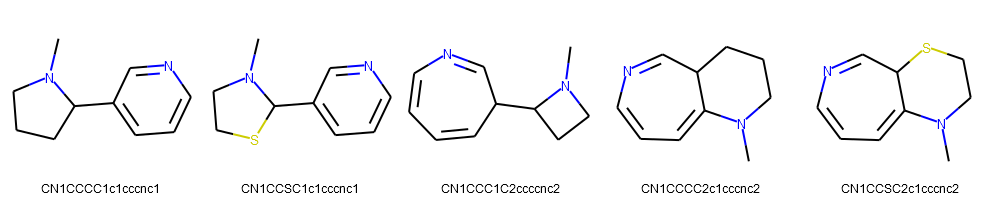

,smiles,distance,count,frequency,mol
0,CN1CCCC1c1cccnc1,0.000003,1,0.1,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CN1CCSC1c1cccnc1,2.412912,6,0.6,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CN1CCC1C2ccccnc2,9.400596,1,0.1,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CN1CCCC2c1cccnc2,10.577662,1,0.1,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CN1CCSC2c1cccnc2,11.371022,1,0.1,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [67]:
noise=35.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_2,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## Interpolate using Slerp


[0.7323833  2.1095202  0.77989966]
Reconstruction       : N1=CSC(c2ccccnc2
Searching molecules randomly sampled from 1.00 std (z-distance) from the point
Found 101 unique mols, out of 639
SMILES
 0             CN1CCCN1c1cccnc1
1             CN1CCSC1c2cccnc2
2             Fn1CCSC1c2cccnc2
3         CN1CCC(c2ccccn2)c1=O
4         Cn1CCSC(c2cccnc2)C1O
5             CN1CCSC1c2ccncc2
6         Cn1CCC(c2cccnc2)c1=O
7             ON1CCC1-c2cccnc2
8         Cn1CCC(-c2cccnc2)C1O
9             Oc1CCSC1c2ccncc2
10        Cn1CCC(c2cccnc2)cc1O
11             ON1CCSc2c1ccnc2
12            Cn1CCCN2c1ccncc2
13            CN1CCCN2c1ccncc2
14            CN1CCOC2c1ccncc2
15            N1=CCCN2c1cccnc2
16            OC1CCCN2c1ccncc2
17            NC1CCCN2c1ccncc2
18            ON1CCCN2c1ccncc2
19            OC1CCOC2c1ccncc2
20            CN1CCC2-c1ccncc2
21            C1=CCCN2c1cccnc2
22            CN1CCC2-c1cccnc2
23            Cn1CCCN2c1cccnc2
24            CN1CCCn2c1cccnc2
25            Cn1CCCn2c1cccnc

C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


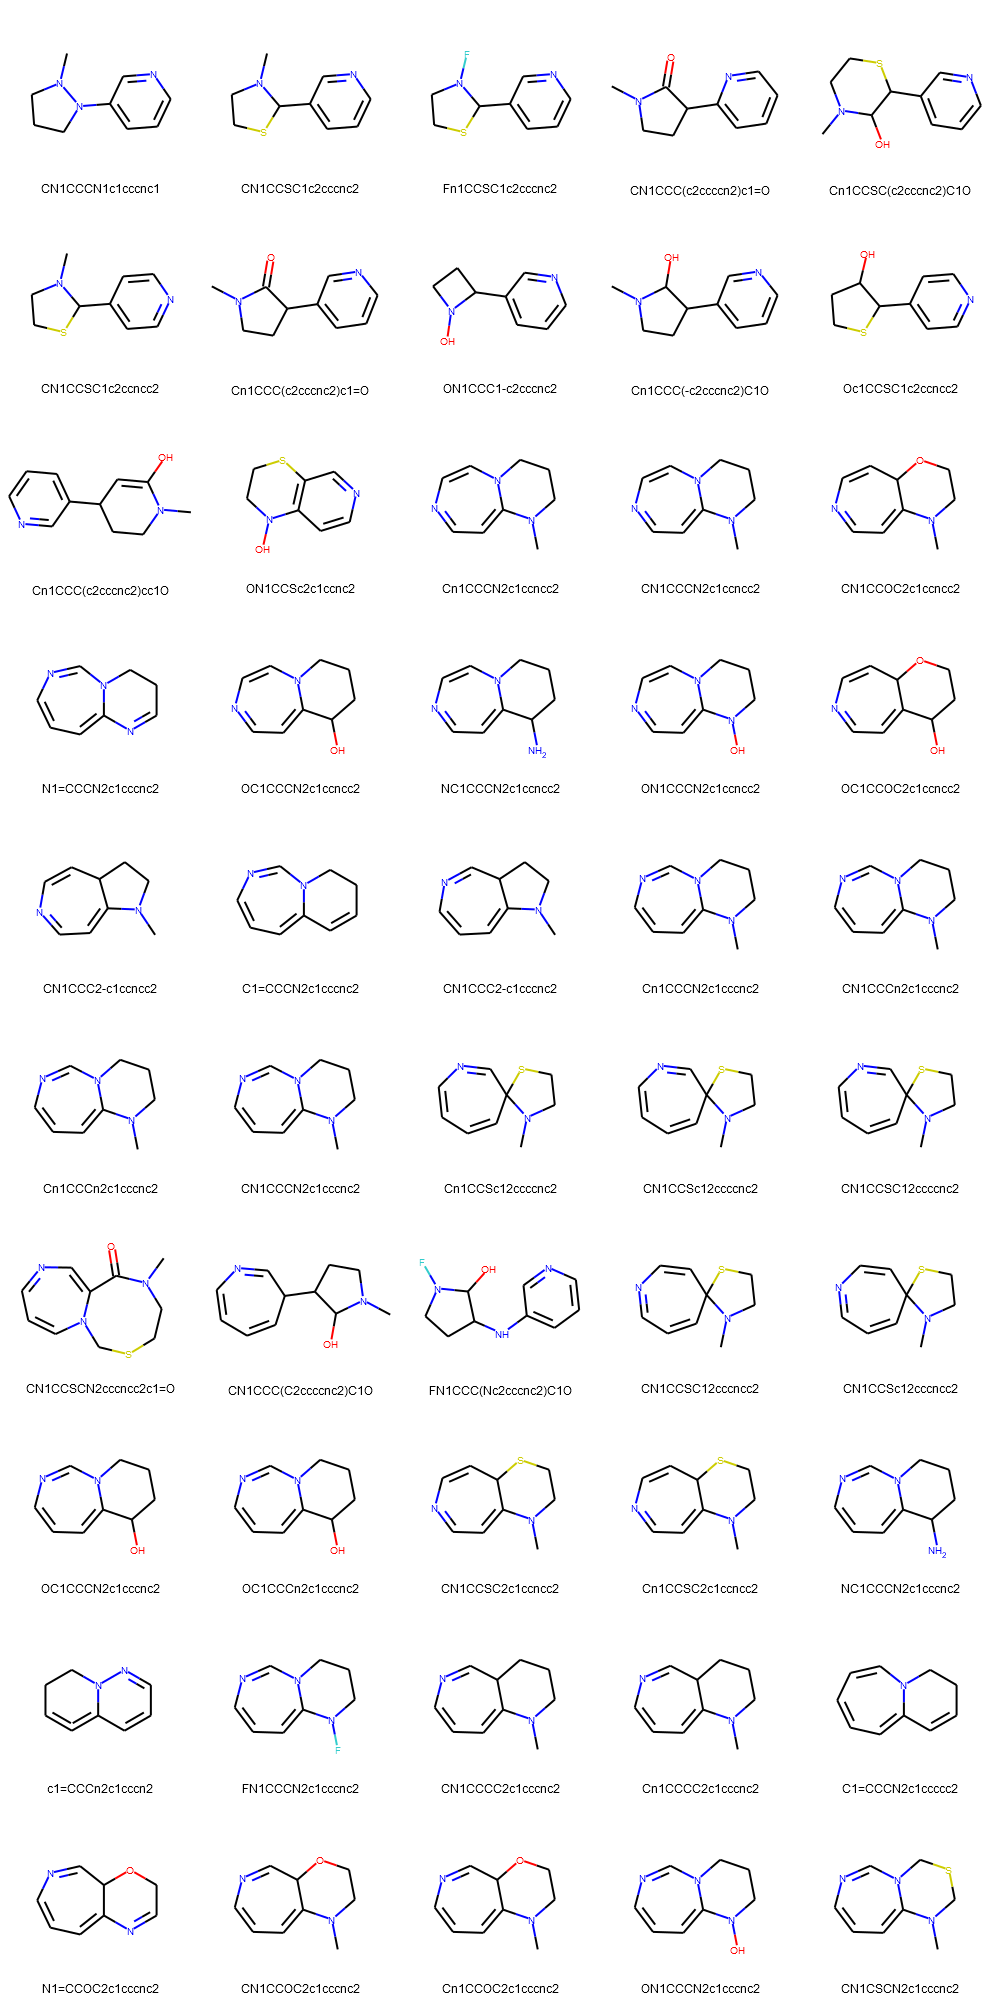

,smiles,distance,count,frequency,mol
0,CN1CCCN1c1cccnc1,8.585196,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CN1CCSC1c2cccnc2,8.694416,2,0.003130,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,Fn1CCSC1c2cccnc2,8.914779,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CN1CCC(c2ccccn2)c1=O,9.020512,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,Cn1CCSC(c2cccnc2)C1O,9.052069,1,0.001565,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [96]:
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy.linalg import norm

def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), np.transpose(high/norm(high))), -1, 1))
    so = sin(omega)
    if so == 0:
    # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

m1=slerp((z_2[0]-z_1[0])/2,z_2,z_1)
y_1 = vae.predict_prop_Z(m1)[0]
print(y_1)

X_r3= vae.decode(m1)


print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r3,strip=True)[0]))

noise=1
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( m1,decode_attempts=10000,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

In [14]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,89692,4.49434,0.719616,1.951276,Cc1noc(C)c1CNc1ccccc1Cc1ccccc1
1,91713,2.74662,0.632078,3.550542,CC(=O)O/N=C1\c2cccn2C[C@H]1CN(C(C)=O)c1ccc(C)cc1
2,211549,2.41880,0.895762,3.137865,C[C@H]1CCC[C@H](NC(=O)CNC(=O)c2ccsc2)[C@@H]1C
3,70154,4.38150,0.717087,2.458092,C[C@H](NC(=O)Nc1ccc(N(C)C)cc1)c1cc2ccccc2o1
4,167540,2.06880,0.767451,4.626188,O=C(Nc1cccc(C[NH+]2CCC(O)CC2)c1)[C@@H]1C[C@@]1...


Perform a PCA projection and color the points based on a property

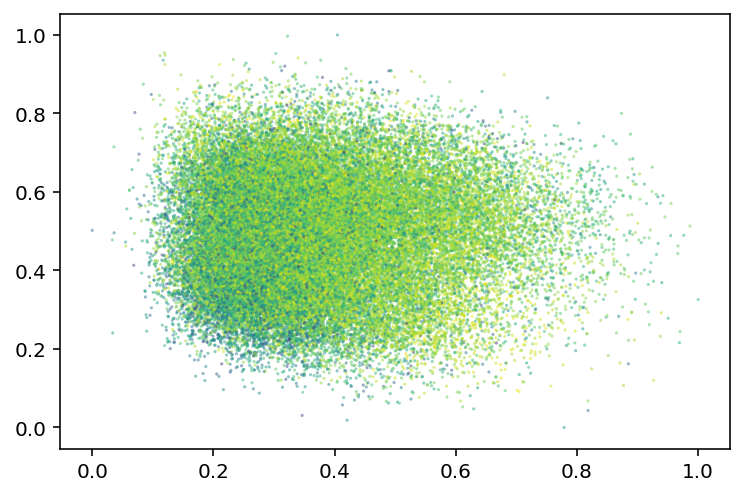

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

In [16]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

f = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

KeyboardInterrupt: 